In [12]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

MAC M1, torch turorial. Originated from https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [14]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


In [15]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Modelling

In [16]:
# mps for Mac 
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To train a model, we need a loss function and an optimizer.

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.



In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [20]:
epochs = 10
history = []
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test_accuracy = test(test_dataloader, model, loss_fn)
    train_accuracy = test(train_dataloader, model, loss_fn)
    history.append(test_accuracy + train_accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307526  [   64/60000]
loss: 2.295039  [ 6464/60000]
loss: 2.271211  [12864/60000]
loss: 2.266528  [19264/60000]
loss: 2.247787  [25664/60000]
loss: 2.221691  [32064/60000]
loss: 2.227292  [38464/60000]
loss: 2.189569  [44864/60000]
loss: 2.188275  [51264/60000]
loss: 2.154033  [57664/60000]
Test Error: 
 Accuracy: 41.6%, Avg loss: 2.147641 

Test Error: 
 Accuracy: 42.2%, Avg loss: 2.146909 

Epoch 2
-------------------------------
loss: 2.157764  [   64/60000]
loss: 2.148431  [ 6464/60000]
loss: 2.085751  [12864/60000]
loss: 2.106699  [19264/60000]
loss: 2.053784  [25664/60000]
loss: 1.991323  [32064/60000]
loss: 2.017994  [38464/60000]
loss: 1.934854  [44864/60000]
loss: 1.945502  [51264/60000]
loss: 1.865372  [57664/60000]
Test Error: 
 Accuracy: 58.8%, Avg loss: 1.868036 

Test Error: 
 Accuracy: 59.4%, Avg loss: 1.865767 

Epoch 3
-------------------------------
loss: 1.905435  [   64/60000]
loss: 1.873114  [ 6464/60000]
loss: 1.7523

# Task 1
Build graphic for the learning process. 

# Load/Save models

In [21]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

Saved PyTorch Model State to model.pth


<All keys matched successfully>

In [22]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


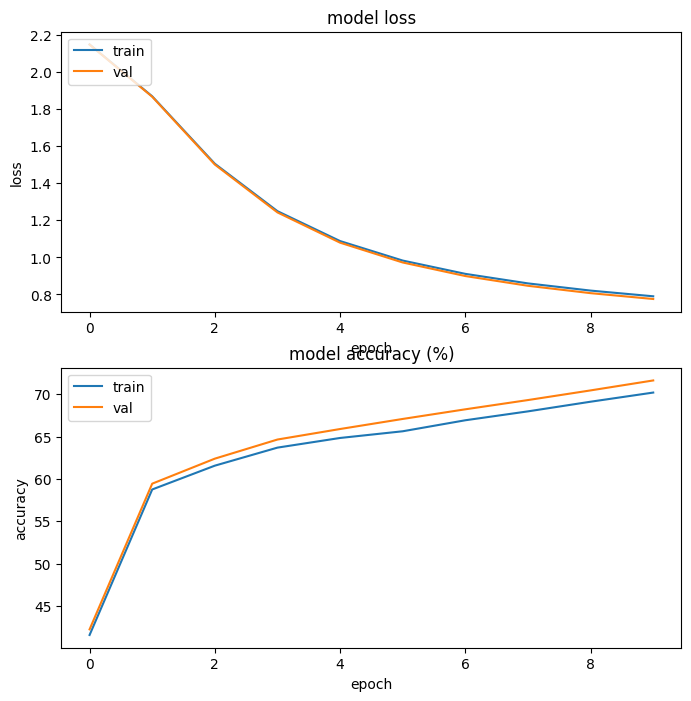

In [26]:
import matplotlib.pyplot as plt

history

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(list(map(lambda h: h[0], history)))
plt.plot(list(map(lambda h: h[2], history)))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(list(map(lambda h: h[1] * 100, history)))
plt.plot(list(map(lambda h: h[3] * 100, history)))
plt.title('model accuracy (%)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()